# Kernel-based Time-varying Regression (KTR)

Complex seasonality is a typical problem in time-series modeling.  For example, in daily time-series data, you may expect a weekly and yearly seasonal pattern within your data. Here we introduce a kernel-based time-varying regression (KTR) to model the trend and complex seasonality. We call it `KTRLite` for now since no regression term is not allowed yet in the model. In the near future, we will introduce another model with the capaticy for exogenous variables. 

In summary, we will cover:

- KTRLite model structure
- Syntax to call, fit and predict in KTRLite 
- Utilities to check / visualize fitting results

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib.pyplot as plt

import orbit
from orbit.models.ktrlite import KTRLiteMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

%matplotlib inline

In [2]:
print(orbit.__version__)

1.0.14dev


## Model Structure

Our goal is to derive an additive form such that 

$$y_t = l_t + s_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $y_t$ is the response variable, $l_t$ is the trend term,  $s_t$ is the complex seasonality term.

In our approach, we can re-write the formula as 

$$y_t = X_t^T\beta_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $\beta_t$ is a $P$-dimensional vector of coefficients vary over time,  $X_t$ is a $P$-dimensional covariate, and $\epsilon_t$ is a stationary random error process.

Here we introduce the idea of expressing $\beta$ as such

$$\beta=Kb^T$$

where

- *knot matrix* $b$ with size $P\times M$  where each entry is a latent vairable  $b_{p, m}$ can be viewed as the "knots" from the perspective of spline regression and
$m$ is a time index such that $m \in [s_1,  \cdots, {s_M}]$ is a subset of $[1, \cdots, T]$.
- *kernel matrix*  $K$  with size $T\times M$ where the $i$th row and $j$th element can be viewed as the noramlied weight $k(t, t_{s_m})/\sum_{m=1}^{M} k(t, t_{s_m})$

For the level/trend,

$$l_t = \beta_{t, \text{lev}}$$

It can also be viewed as a dynamic intercept.

For the seasonality,

$$\beta_{\text{seas}} = K_{\text{seas}}b^T_{\text{seas}}$$

$$s_t = X_{t, \text{seas}}\beta_{t, \text{seas}}$$


We use Fourier series to handle the seasonality such that seasonality terms can be expressed in a matrix $X_{seas}$.

There are different choices of $kernel function$ and prior for matrix $b$. We don't discuss the details here. 

## Data

To illustrate the usage of KTRLite, we use the daily series of electricity demand in Turkey from year 2000 to year 2008. It is good to model the dual seasonality (weekly and yearly), since it's a daily series.

In [3]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()
date_col = 'date'
response_col = 'electricity'
df[response_col] = np.log(df[response_col])
print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [4]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

Split the data into training set and test set.

In [5]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In orbit, we only provide one type of KTRLite model, `KTRLiteMAP`, using Stan as the underlying sampling engine.

Similar to other model types in Orbit, it follows a sklearn style model API. We can create an instance of the Orbit class and then call its fit and predict methods.

Multiple flexible ways are available to control the number of knots in the model. 
* span_level: relative window width between two knots; e.g. `.05` means `20` evenly distributed knots
* level_knot_dates: a list of dates corresponding to the knots.
* level_knot_length: the distance between every two knots.

In [6]:
ktrlite = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
)

In [7]:
ktrlite.fit(train_df)

In [8]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.89904,10.01165,10.12095,9.90536,9.99508,10.08227,0.02478,0.02478,0.02478,-0.00820,-0.00820,-0.00820
1,2008-01-03,9.90303,10.01374,10.12522,9.90376,9.99508,10.08382,0.02745,0.02745,0.02745,-0.00879,-0.00879,-0.00879
2,2008-01-04,9.91232,10.02801,10.14023,9.90216,9.99508,10.08538,0.04215,0.04215,0.04215,-0.00922,-0.00922,-0.00922
3,2008-01-05,9.83879,9.95544,10.06654,9.90055,9.99508,10.08694,-0.03015,-0.03015,-0.03015,-0.00949,-0.00949,-0.00949
4,2008-01-06,9.78003,9.89762,10.01268,9.89895,9.99508,10.08849,-0.08785,-0.08785,-0.08785,-0.00961,-0.00961,-0.00961


## Diagnostic

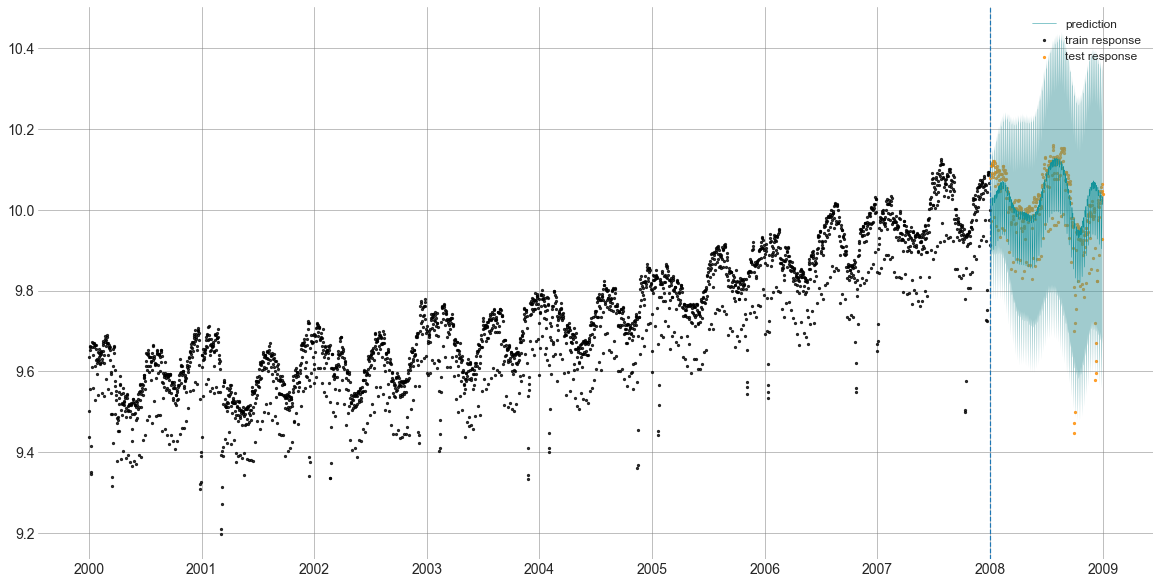

In [9]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df, markersize=20, lw=.5)

In [10]:
'SMAPE:{:.2%}'.format(smape(predicted_df['prediction'].values, test_df['electricity'].values))

'SMAPE:0.46%'

We can use `plot_predicted_components` to visualize each component.

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/diagnostics/plot.py:223: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


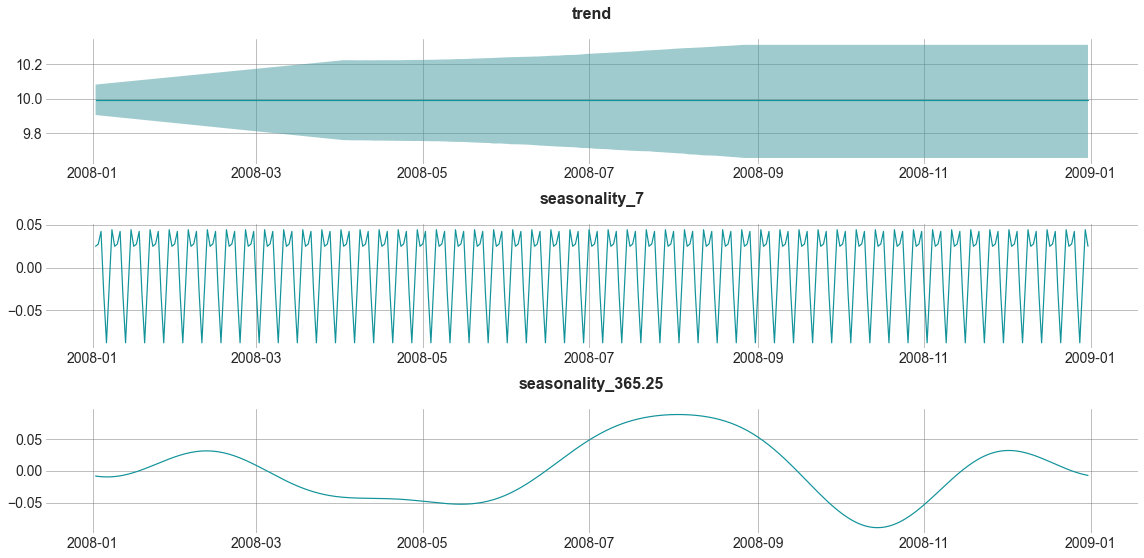

In [11]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

Moreover, we can use `plot_lev_knots` from the object to inspect the shift of the segment divided by the knots.

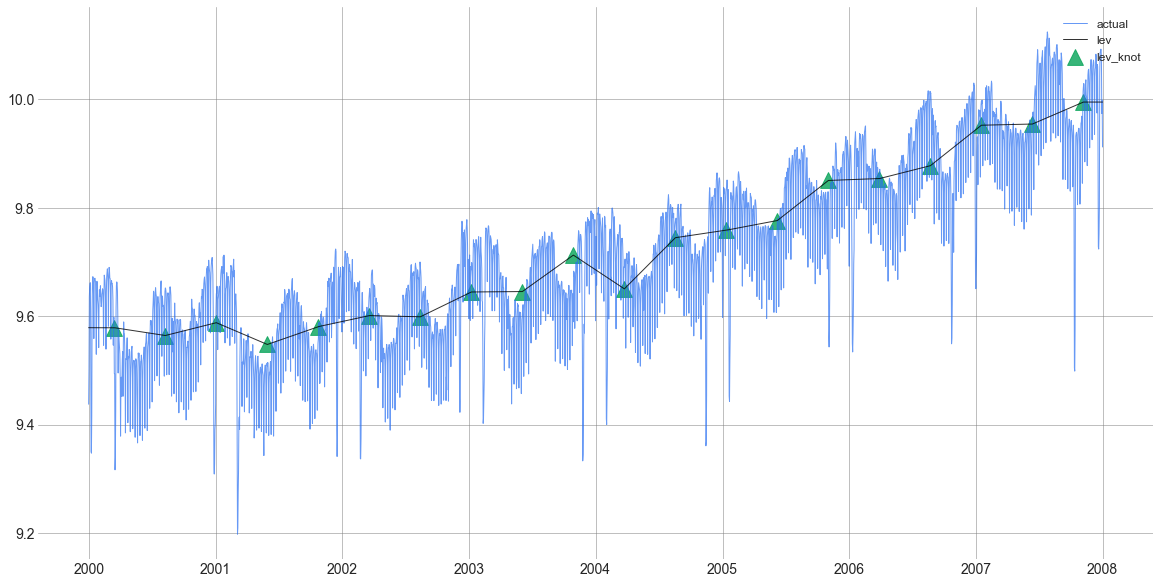

In [12]:
_ = ktrlite.plot_lev_knots()

Some utilies to retreive levels and level knots information.

In [13]:
lev_knots_df = ktrlite.get_level_knots()
lev_knots_df.head(5)

,date,lev_knot
0,2000-03-15,9.57878
1,2000-08-09,9.56434
2,2001-01-03,9.58799
3,2001-05-30,9.54782
4,2001-10-24,9.58073


In [14]:
lev_df = ktrlite.get_levels()
lev_df.head(5)

,date,lev
0,2000-01-01,9.57878
1,2000-01-02,9.57878
2,2000-01-03,9.57878
3,2000-01-04,9.57878
4,2000-01-05,9.57878
